# The Ultimate Guide for Clustering Mixed Data

Este notebook está basado en el artículo de Medium "The Ultimate Guide for Clustering Mixed Data" (https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b).

Vamos a explorar diferentes técnicas para el clustering de datos mixtos (numéricos y categóricos).

## Instalación de las bibliotecas necesarias

In [ ]:
# Instalamos las bibliotecas necesarias
# se puede hacer en el terminal con el comando cuando se cree el .venv
#!pip install numpy pandas matplotlib seaborn scikit-learn kmodes sklearn-contrib-py-earth prince distance-metrics gower

## Importación de bibliotecas

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as shc
import gower
from sklearn.metrics import silhouette_score

## Carga del Dataset

Usaremos un dataset clásico: el Adult Income dataset (Census Income)

In [10]:
# Cargar el dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['edad', 'clase_laboral', 'fnlwgt', 'educacion', 'num_educacion', 
'estado civil', 'ocupacion', 'parentesco', 'raza', 'sexo', 
'ganancia_capital', 'pérdida_capital', 'horas_semanales', 'pais_origen', 'ingresos']

df = pd.read_csv(url, names=column_names, sep=',\s', engine='python')
df.head()

,edad,clase_laboral,fnlwgt,educacion,num_educacion,estado civil,ocupacion,parentesco,raza,sexo,ganancia_capital,pérdida_capital,horas_semanales,pais_origen,ingresos
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
# Verificar la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   edad              32561 non-null  int64 
 1   clase_laboral     32561 non-null  object
 2   fnlwgt            32561 non-null  int64 
 3   educacion         32561 non-null  object
 4   num_educacion     32561 non-null  int64 
 5   estado civil      32561 non-null  object
 6   ocupacion         32561 non-null  object
 7   parentesco        32561 non-null  object
 8   raza              32561 non-null  object
 9   sexo              32561 non-null  object
 10  ganancia_capital  32561 non-null  int64 
 11  pérdida_capital   32561 non-null  int64 
 12  horas_semanales   32561 non-null  int64 
 13  pais_origen       32561 non-null  object
 14  ingresos          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [12]:
# Estadísticas descriptivas
df.describe()

,edad,fnlwgt,num_educacion,ganancia_capital,pérdida_capital,horas_semanales
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


## Preprocesamiento de Datos

In [13]:
# Verificar valores nulos
df.isnull().sum()

edad                0
clase_laboral       0
fnlwgt              0
educacion           0
num_educacion       0
estado civil        0
ocupacion           0
parentesco          0
raza                0
sexo                0
ganancia_capital    0
pérdida_capital     0
horas_semanales     0
pais_origen         0
ingresos            0
dtype: int64

In [14]:
# Verificar valores únicos en las columnas categóricas
print("Valores únicos en las columnas categóricas:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} valores únicos")
    print(df[col].unique()[:5])

Valores únicos en las columnas categóricas:
clase_laboral: 9 valores únicos
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov']
educacion: 16 valores únicos
['Bachelors' 'HS-grad' '11th' 'Masters' '9th']
estado civil: 7 valores únicos
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated']
ocupacion: 15 valores únicos
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service']
parentesco: 6 valores únicos
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried']
raza: 5 valores únicos
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sexo: 2 valores únicos
['Male' 'Female']
pais_origen: 42 valores únicos
['United-States' 'Cuba' 'Jamaica' 'India' '?']
ingresos: 2 valores únicos
['<=50K' '>50K']


In [15]:
# Reemplazar '?' con NaN y verificar valores faltantes
df.replace(' ?', np.nan, inplace=True)
df.isnull().sum()

edad                0
clase_laboral       0
fnlwgt              0
educacion           0
num_educacion       0
estado civil        0
ocupacion           0
parentesco          0
raza                0
sexo                0
ganancia_capital    0
pérdida_capital     0
horas_semanales     0
pais_origen         0
ingresos            0
dtype: int64

In [16]:
# Eliminar filas con valores nulos
df_clean = df.dropna()
print(f"Filas originales: {df.shape[0]}, Filas después de eliminar valores nulos: {df_clean.shape[0]}")

Filas originales: 32561, Filas después de eliminar valores nulos: 32561


In [17]:
# Tomar una muestra más pequeña para acelerar el procesamiento
df_sample = df_clean.sample(n=5000, random_state=42)
print(f"Forma de la muestra: {df_sample.shape}")

Forma de la muestra: (5000, 15)


In [18]:
# Identificar columnas numéricas y categóricas
numeric_cols = df_sample.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_sample.select_dtypes(include=['object']).columns.tolist()

print(f"Columnas numéricas: {numeric_cols}")
print(f"Columnas categóricas: {categorical_cols}")

Columnas numéricas: ['edad', 'fnlwgt', 'num_educacion', 'ganancia_capital', 'pérdida_capital', 'horas_semanales']
Columnas categóricas: ['clase_laboral', 'educacion', 'estado civil', 'ocupacion', 'parentesco', 'raza', 'sexo', 'pais_origen', 'ingresos']


## Método 1: K-Means solo con variables numéricas

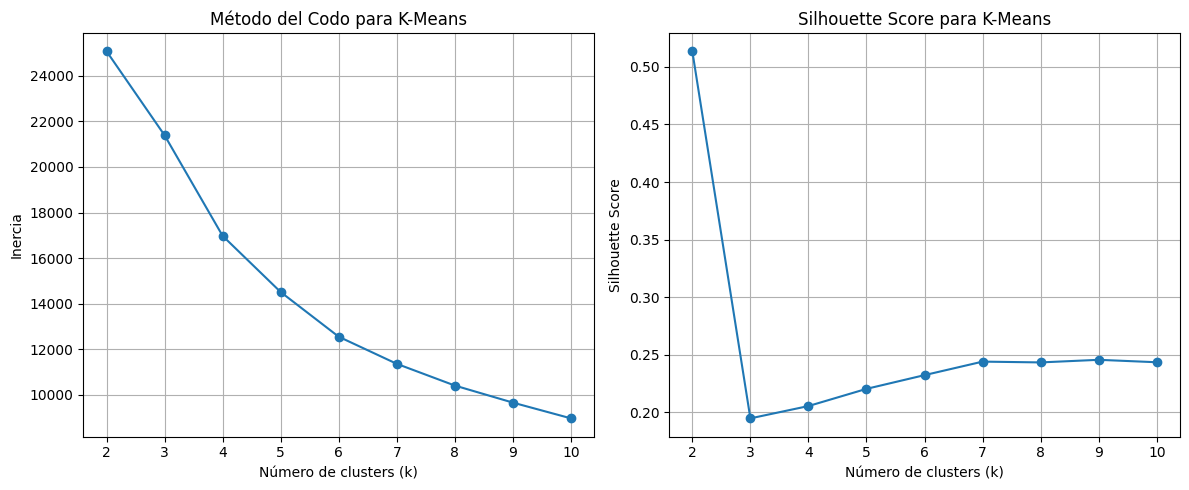

In [19]:
# Extraer solo las variables numéricas y escalarlas
X_num = df_sample[numeric_cols].copy()
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Encontrar el número óptimo de clusters usando el método del codo
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_num_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_num_scaled, kmeans.labels_))
    
# Graficar el método del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para K-Means')
plt.grid(True)

plt.tight_layout()
plt.show()

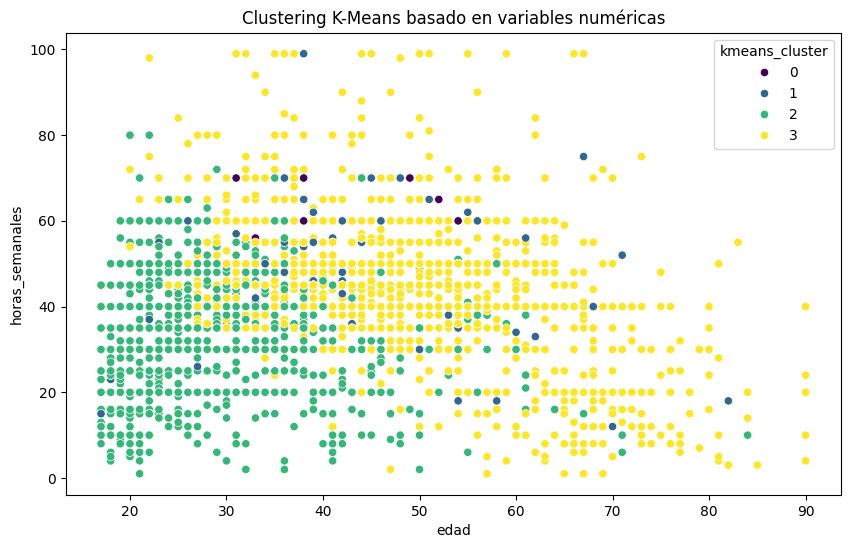

In [22]:
# Aplicar K-Means con el número óptimo de clusters determinado
optimal_k = 4  # Ajustar según los resultados del método del codo
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_num_scaled)

# Añadir las etiquetas al dataframe
df_sample['kmeans_cluster'] = kmeans_labels

# Visualizar los resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sample,
    x='edad',  # Cambia 'age' por 'edad'
    y='horas_semanales',  # Cambia 'hours-per-week' por 'horas_semanales'
    hue='kmeans_cluster',  # Asegúrate de que esta columna exista
    palette='viridis'
)
plt.title('Clustering K-Means basado en variables numéricas')
plt.show()

## Método 2: K-Modes solo con variables categóricas

Ejecutando K-Modes con k=2...
Ejecutando K-Modes con k=3...
Ejecutando K-Modes con k=4...
Ejecutando K-Modes con k=5...
Ejecutando K-Modes con k=6...
Ejecutando K-Modes con k=7...
Ejecutando K-Modes con k=8...
Ejecutando K-Modes con k=9...
Ejecutando K-Modes con k=10...


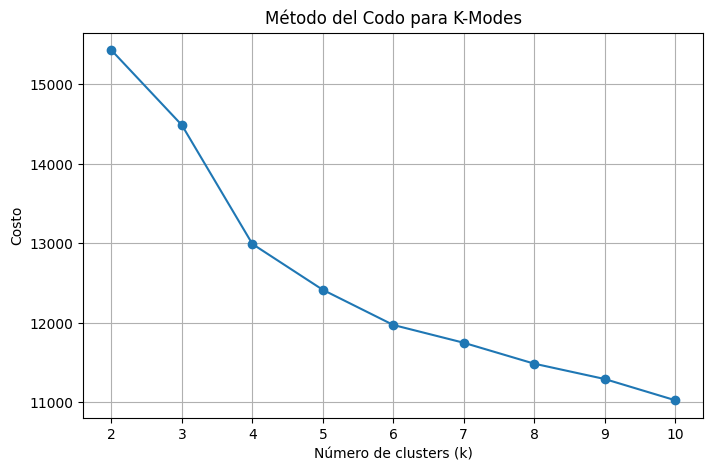

In [23]:
# Extraer solo las variables categóricas
X_cat = df_sample[categorical_cols].copy()

# Encontrar el número óptimo de clusters usando K-Modes
cost = []
k_range = range(2, 11)

for k in k_range:
    print(f"Ejecutando K-Modes con k={k}...")
    kmode = KModes(n_clusters=k, init='Huang', n_init=5, random_state=42, verbose=0)
    kmode.fit_predict(X_cat)
    cost.append(kmode.cost_)
    
# Graficar el método del codo para K-Modes
plt.figure(figsize=(8, 5))
plt.plot(k_range, cost, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Costo')
plt.title('Método del Codo para K-Modes')
plt.grid(True)
plt.show()

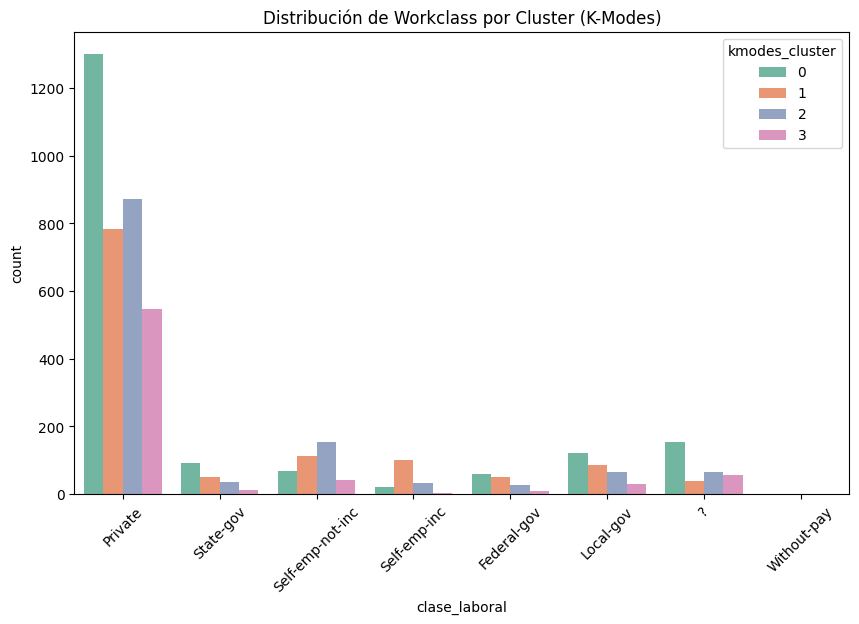

In [27]:
# Aplicar K-Modes con el número óptimo de clusters determinado
optimal_k = 4  # Ajustar según los resultados del método del codo
kmode = KModes(n_clusters=optimal_k, init='Huang', n_init=5, random_state=42, verbose=0)
kmodes_labels = kmode.fit_predict(X_cat)

# Añadir las etiquetas al dataframe
df_sample['kmodes_cluster'] = kmodes_labels

# Visualizar los resultados
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, x='clase_laboral', hue='kmodes_cluster', palette='Set2')
plt.title('Distribución de Workclass por Cluster (K-Modes)')
plt.xticks(rotation=45)
plt.show()

## Método 3: K-Prototypes para datos mixtos

In [ ]:
# Aplicar K-Prototypes
# Identificar índices de columnas categóricas
df_for_kprototypes = df_sample.copy()
categorical_indices = [df_for_kprototypes.columns.get_loc(col) for col in categorical_cols]

# Encontrar el número óptimo de clusters usando K-Prototypes
cost = []
k_range = range(2, 11)

for k in k_range:
    print(f"Ejecutando K-Prototypes con k={k}...")
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=5, random_state=42, verbose=0)
    kproto.fit_predict(df_for_kprototypes.values, categorical=categorical_indices)
    cost.append(kproto.cost_)
    
# Graficar el método del codo para K-Prototypes
plt.figure(figsize=(8, 5))
plt.plot(k_range, cost, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Costo')
plt.title('Método del Codo para K-Prototypes')
plt.grid(True)
plt.show()

Ejecutando K-Prototypes con k=2...
Ejecutando K-Prototypes con k=3...
Ejecutando K-Prototypes con k=4...
Ejecutando K-Prototypes con k=5...
Ejecutando K-Prototypes con k=6...
Ejecutando K-Prototypes con k=7...
Ejecutando K-Prototypes con k=8...


In [ ]:
# Aplicar K-Prototypes con el número óptimo de clusters determinado
optimal_k = 4  # Ajustar según los resultados del método del codo
kproto = KPrototypes(n_clusters=optimal_k, init='Huang', n_init=5, random_state=42, verbose=0)
kproto_labels = kproto.fit_predict(df_for_kprototypes.values, categorical=categorical_indices)

# Añadir las etiquetas al dataframe
df_sample['kproto_cluster'] = kproto_labels

# Visualizar los resultados de clustering
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico numérico
sns.scatterplot(data=df_sample, x='age', y='hours-per-week', hue='kproto_cluster', palette='viridis', ax=axes[0])
axes[0].set_title('K-Prototypes: Age vs Hours-per-week')

# Gráfico categórico
sns.countplot(data=df_sample, x='workclass', hue='kproto_cluster', palette='viridis', ax=axes[1])
axes[1].set_title('K-Prototypes: Distribución de Workclass por Cluster')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Método 4: Clustering Jerárquico con Distancia de Gower

In [ ]:
# Tomar una muestra más pequeña para el clustering jerárquico (es computacionalmente intensivo)
df_hier_sample = df_sample.sample(n=1000, random_state=42)

# Preparar datos para distancia de Gower
X_gower = df_hier_sample.copy()

# Calcular matriz de distancia de Gower
gower_matrix = gower.gower_matrix(X_gower)

# Crear dendrograma
plt.figure(figsize=(12, 8))
dend = shc.dendrogram(shc.linkage(gower_matrix, method='ward'))
plt.title('Dendrograma de Clustering Jerárquico con Distancia de Gower')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.axhline(y=6, color='r', linestyle='--')
plt.show()

In [ ]:
# Aplicar clustering jerárquico con el número de clusters determinado por el dendrograma
from scipy.cluster.hierarchy import fcluster

optimal_k = 4  # Determinar en base al dendrograma
hierarchical_labels = fcluster(shc.linkage(gower_matrix, method='ward'), optimal_k, criterion='maxclust')

# Añadir etiquetas al dataframe
df_hier_sample['hierarchical_cluster'] = hierarchical_labels

# Visualizar los resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico numérico
sns.scatterplot(data=df_hier_sample, x='age', y='hours-per-week', hue='hierarchical_cluster', palette='viridis', ax=axes[0])
axes[0].set_title('Clustering Jerárquico: Age vs Hours-per-week')

# Gráfico categórico
sns.countplot(data=df_hier_sample, x='workclass', hue='hierarchical_cluster', palette='viridis', ax=axes[1])
axes[1].set_title('Clustering Jerárquico: Distribución de Workclass por Cluster')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Comparación de resultados de los diferentes métodos

In [ ]:
# Crear un dataframe para comparar los resultados de clustering para cada método
# Necesitamos asegurar que estamos trabajando con el mismo conjunto de datos para la comparación
df_comparison = df_sample.head(1000).copy()  # Usar las primeras 1000 filas que deberían estar en todos los conjuntos

# Verificar si tenemos todos los métodos aplicados a este subconjunto
methods_to_compare = []

if 'kmeans_cluster' in df_sample.columns:
    df_comparison['kmeans_cluster'] = df_sample.head(1000)['kmeans_cluster']
    methods_to_compare.append('kmeans_cluster')

if 'kmodes_cluster' in df_sample.columns:
    df_comparison['kmodes_cluster'] = df_sample.head(1000)['kmodes_cluster']
    methods_to_compare.append('kmodes_cluster')

if 'kproto_cluster' in df_sample.columns:
    df_comparison['kproto_cluster'] = df_sample.head(1000)['kproto_cluster']
    methods_to_compare.append('kproto_cluster')

# Para el clustering jerárquico, necesitamos verificar si los índices coinciden
if 'hierarchical_cluster' in df_hier_sample.columns and set(df_comparison.index).issubset(set(df_hier_sample.index)):
    df_comparison = df_comparison.join(df_hier_sample[['hierarchical_cluster']], how='left')
    methods_to_compare.append('hierarchical_cluster')

# Función para calcular el Adjusted Rand Index (ARI) entre dos métodos
from sklearn.metrics import adjusted_rand_score

# Crear una matriz de similitud entre métodos
if len(methods_to_compare) > 1:
    similarity_matrix = pd.DataFrame(index=methods_to_compare, columns=methods_to_compare)
    
    for method1 in methods_to_compare:
        for method2 in methods_to_compare:
            if method1 == method2:
                similarity_matrix.loc[method1, method2] = 1.0
            else:
                # Asegurarse de que no hay NaN en las columnas
                mask = ~(df_comparison[method1].isna() | df_comparison[method2].isna())
                if mask.sum() > 0:
                    similarity_matrix.loc[method1, method2] = adjusted_rand_score(
                        df_comparison[method1][mask], df_comparison[method2][mask])
                else:
                    similarity_matrix.loc[method1, method2] = np.nan
    
    # Visualizar la matriz de similitud
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, cmap='viridis', vmin=0, vmax=1)
    plt.title('Similitud entre diferentes métodos de clustering (Adjusted Rand Index)')
    plt.show()
else:
    print("No hay suficientes métodos para comparar.")

## Caracterización de los clusters

Vamos a analizar las características de los clusters obtenidos con K-Prototypes, que es el método más adecuado para datos mixtos.

In [ ]:
# Analizar características de los clusters de K-Prototypes
if 'kproto_cluster' in df_sample.columns:
    # Analizar variables numéricas por cluster
    numeric_analysis = df_sample.groupby('kproto_cluster')[numeric_cols].agg(['mean', 'median', 'std'])
    print("Análisis de variables numéricas por cluster:")
    display(numeric_analysis)
    
    # Visualizar distribuciones de variables numéricas por cluster
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numeric_cols[:4]):  # Limitar a las primeras 4 variables numéricas
        plt.subplot(2, 2, i+1)
        sns.boxplot(data=df_sample, x='kproto_cluster', y=col)
        plt.title(f'Distribución de {col} por cluster')
    plt.tight_layout()
    plt.show()
    
    # Analizar variables categóricas por cluster
    for col in categorical_cols[:3]:  # Limitar a las primeras 3 variables categóricas
        plt.figure(figsize=(14, 6))
        crosstab = pd.crosstab(df_sample['kproto_cluster'], df_sample[col], normalize='index')
        crosstab.plot(kind='bar', stacked=True)
        plt.title(f'Distribución de {col} por cluster (proporción)')
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=0)
        plt.show()
else:
    print("K-Prototypes no ha sido aplicado al dataframe.")

## Conclusiones

En este notebook, hemos explorado diferentes métodos para el clustering de datos mixtos (numéricos y categóricos):

1. **K-Means**: Solo utiliza variables numéricas. Es simple y eficiente, pero ignora la información categórica.

2. **K-Modes**: Solo utiliza variables categóricas. Es útil cuando las variables categóricas son dominantes en el dataset.

3. **K-Prototypes**: Combina K-Means y K-Modes para manejar datos mixtos. Ofrece una solución integral cuando ambos tipos de variables son importantes.

4. **Clustering Jerárquico con Distancia de Gower**: Proporciona una forma flexible de manejar datos mixtos y visualizar la estructura jerárquica de los clusters.

### Observaciones clave:

- La elección del método debe basarse en la naturaleza de los datos y los objetivos del análisis.
- K-Prototypes suele ser la mejor opción cuando se tienen datos mixtos y se quiere considerar toda la información disponible.
- El clustering jerárquico con distancia de Gower es útil para explorar la estructura natural de los datos y determinar el número óptimo de clusters.
- Es importante analizar y caracterizar los clusters resultantes para entender los patrones descubiertos.

Para aplicaciones prácticas, el método elegido debería validarse mediante métricas internas (como Silhouette Score) y evaluación experta del significado de los clusters en el contexto del problema.